# Plot Aggregate

Notebook to load experiment results and plot the following:
* Average contact map of the jet locations from the results
    * 1D tracks (optional)
* Histogram of the distribution of jet lengths in basepairs

In [1]:
import pandas as pd
import hicstraw
import bioframe as bf
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import cv2 as cv

import sys
sys.path.append('..')
from utils.plotting import plot_hic, plot_n_hic, genomic_labels

In [2]:
def get_pileups_dynamic_resolution(
    hic_file,
    bed_df_in,
    expected_stack_size,
    chrom_sizes,
    chromosomes='all',
    window_range=(None, None),
    data_type="observed",
    normalization="KR",
    sort=False
):
    """
    Generates Hi-C pileups for each region in bed_df_in, choosing for each
    region the resolution (from hic.getResolutions()) that makes
    (region_length / resolution) as close as possible to expected_stack_size.

    Parameters
    ----------
    hic_file : str
        Path to your Hi-C .hic file.
    bed_df_in : pandas.DataFrame
        Must contain columns ['chrom', 'start', 'end'].
    expected_stack_size : int
        Desired number of bins per side of your square pileup.
    chrom_sizes : pandas.DataFrame
        Columns ['chrom', 'length'] (or 'name','length' after trimming).
    chromosomes : 'all' | list of str | str
        Which chroms to include.
    window_range : tuple(int|None, int|None)
        (upstream, downstream) around the midpoint to override bed_df_in.
    data_type : str
        e.g. "observed", "oe", etc.
    normalization : str
        e.g. "KR", "VC", ...
    sort : bool
        If True, sorts bed_df naturally by chrom, start, end.

    Returns
    -------
    pileups : list of 2D np.ndarray
        Each is a square matrix of Hi-C contacts at the chosen resolution.
    bed_df_out : pandas.DataFrame
        The (possibly trimmed, sorted) DataFrame actually used.
    """

    # 1) Copy & optional sort
    bed_df = bed_df_in.copy()
    if sort:
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            return {'x':23,'y':24,'m':25,'mt':25}.get(cl[-2:] if len(cl)>1 else cl[-1],100)
        bed_df['_ck'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['_ck','start','end']).drop(columns=['_ck']).reset_index(drop=True)

    # 2) apply window_range if given
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['mid'] = ((bed_df['start'] + bed_df['end'])//2)
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['mid'] - win_up
        bed_df['end']   = bed_df['mid'] + win_down
        bed_df = bed_df.drop(columns=['mid'])
        # bioframe.trim wants a 'name' column on chrom_sizes
        chrom_sizes = chrom_sizes.copy()
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes).dropna().reset_index(drop=True)
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)

    # 3) restrict to desired chromosomes
    if chromosomes == 'all':
        chrom_set = bed_df['chrom'].unique().tolist()
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        chrom_set = list(set(bed_df['chrom']).intersection(chromosomes))
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # 4) open hic & fetch available resolutions
    hic = hicstraw.HiCFile(hic_file)
    avail_res = sorted(hic.getResolutions())  # e.g. [500,1000,5000,...]

    # detect whether 'chr' prefix is used in the file
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # 5) build pileups
    pileups = []
    selected_resolutions = []
    for _, row in tqdm(bed_df.iterrows(), total=len(bed_df), desc="dynamic-res"):
        chrom = row['chrom']
        key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom

        # compute region length
        length = int(row['end']) - int(row['start'])

        # choose resolution that makes length/res ≈ expected_stack_size
        best_res = min(
            avail_res,
            key=lambda r: abs((length / r) - expected_stack_size)
        )

        selected_resolutions.append(best_res)

        # fetch matrix zoom data at that resolution
        mzd = hic.getMatrixZoomData(
            key, key,
            data_type, normalization,
            'BP',
            best_res
        )

        # extract the pileup
        mat = mzd.getRecordsAsMatrix(
            int(row['start']), int(row['end']),
            int(row['start']), int(row['end'])
        )
        pileups.append(mat)

    return pileups, bed_df, selected_resolutions



def get_pileups(hic_file, bed_df_in, resolution, chrom_sizes,
                chromosomes='all', window_range=(None, None),
                data_type="observed", normalization="KR", sort=False):
    """
    Processes Hi-C data to generate pileups for genomic regions specified in a BED-format DataFrame

    Returns:
    --------
    pileups : list of numpy arrays
        Each array is a pileup matrix of Hi-C interaction data.
    bed_df  : pandas DataFrame
        Possibly sorted and trimmed bed DataFrame used for pileups.
    """
    bed_df = bed_df_in.copy()

    # Optional sort on natural chromosome order
    if sort:
        # Define a key function for numeric and special chromosomes
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            if cl.endswith('x'):
                return 23
            if cl.endswith('y'):
                return 24
            if cl.endswith(('m', 'mt')):
                return 25
            return 100

        bed_df['sort_key'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['sort_key', 'start', 'end'])
        bed_df = bed_df.drop(columns=['sort_key']).reset_index(drop=True)

    # Handle custom window around midpoints
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['midpoint'] = ((bed_df['start'] + bed_df['end']) // 2)
        # default missing values
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['midpoint'] - win_up
        bed_df['end'] = bed_df['midpoint'] + win_down
        bed_df = bed_df.drop(columns=['midpoint'])
        # Trim out-of-bounds
        # bioframe.trim expects a 'name' column on chrom_sizes
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes)
        bed_df = bed_df.dropna().reset_index(drop=True)
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)

    # Determine which chromosomes to include
    if chromosomes == 'all':
        chrom_set = list(bed_df['chrom'].unique())
    elif isinstance(chromosomes, (list, np.ndarray)):
        chrom_set = list(set(bed_df['chrom'].unique()) & set(chromosomes))
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        print(f"Warning: 'chromosomes' argument improperly formatted: {chromosomes}")
        chrom_set = list(bed_df['chrom'].unique())

    # Filter bed_df by chrom_set in both branches
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # Open Hi-C file and detect prefix usage
    hic = hicstraw.HiCFile(hic_file)
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # Build pileups
    pileups = []
    if sort:
        for chrom in chrom_set:
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            sub = bed_df[bed_df['chrom'] == chrom]
            for _, row in tqdm(sub.iterrows(), total=len(sub)):
                mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                             int(row['start']), int(row['end']))
                pileups.append(mat)
    else:
        for _, row in tqdm(bed_df.iterrows(), total=len(bed_df)):
            chrom = row['chrom']
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                         int(row['start']), int(row['end']))
            pileups.append(mat)

    return pileups, bed_df


def remove_stack_centromeres(stack, stack_positions, expected_stack_size):
    '''
    Essentially removes Hi-C windows in the stack that are not size `expected_stack_size`
    Returns modified stack, stack_positions
    '''
    # process centromeres
    stack_uniform = []
    problem = []
    for i, each in enumerate(stack):
        if each.shape[0] != expected_stack_size:
            problem.append(i)
        else:
            stack_uniform.append(each)

    stack = np.array(stack_uniform)
    stack_positions = stack_positions.drop(problem, axis=0).reset_index(drop=True)
    assert stack.shape[0] == len(stack_positions)
    return stack, stack_positions


def remove_and_resize_square_stacks(stack, stack_positions, expected_stack_size):
    """
    Filters out any arrays in `stack` that aren’t square, then
    resizes the remaining square arrays to (expected_stack_size, expected_stack_size).

    Parameters
    ----------
    stack : Sequence of 2D numpy arrays
        Each array should represent a Hi-C window.
    stack_positions : pandas.DataFrame
        Positions corresponding to each entry in `stack`.
    expected_stack_size : int
        The desired width and height for all retained windows.

    Returns
    -------
    (np.ndarray, pandas.DataFrame)
        - stack_resized: Array of shape (n_retained, expected_stack_size, expected_stack_size)
        - stack_positions_filtered: DataFrame of length n_retained
    """
    stack_uniform = []
    bad_indices = []

    for i, arr in enumerate(stack):
        # check it's 2D and square
        if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
            bad_indices.append(i)
            continue

        # resize square array to expected_stack_size × expected_stack_size
        resized = cv.resize(
            arr,
            (expected_stack_size, expected_stack_size),
            interpolation=cv.INTER_AREA
        )
        stack_uniform.append(resized)

    # build numpy array of resized windows
    stack_resized = np.array(stack_uniform)

    # drop bad rows from positions, reset index
    stack_positions_filtered = (
        stack_positions
        .drop(index=bad_indices, errors='ignore')
        .reset_index(drop=True)
    )

    # sanity check
    assert stack_resized.shape[0] == len(stack_positions_filtered), (
        f"Number of retained stacks ({stack_resized.shape[0]}) "
        f"does not match positions ({len(stack_positions_filtered)})"
    )

    return stack_resized, stack_positions_filtered

In [3]:
# Let the notebook know what result you want to aggregate and analyze
# Specify the "*_expanded_table.csv" file (either a single chromosome, or whole genome after running `combine_results.ipynb`)

f_expanded_table = "/nfs/turbo/umms-minjilab/sionkim/miajet_output/splenic-B-cell_WT_insitu-hic_GSE82144_mm9_chr_combined_50Kb/splenic-B-cell_WT_insitu-hic_GSE82144_mm9_chr_combined_saliency-90-p-0.1_50Kb_expanded_table.csv"
f_summary_table = "/nfs/turbo/umms-minjilab/sionkim/miajet_output/splenic-B-cell_WT_insitu-hic_GSE82144_mm9_chr_combined_50Kb/splenic-B-cell_WT_insitu-hic_GSE82144_mm9_chr_combined_saliency-90-p-0.1_50Kb_summary_table.csv"

hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic"

# Specify the genome (i.e. assembly)
# Exampels: "hg38", ""
genome = "mm9"

# Note that these parmameters need not be the same as the parameters used to call the jets
# This resolution is used for plotting purposes 
# resolution = 50000  
data_type = "oe"
normalization = "KR"
# window_size = 2e6
# expected_stack_size = np.ceil(window_size / resolution + 1).astype(int)
expected_stack_size = 100

In [32]:
# Load in tables
df_expanded = pd.read_csv(f_expanded_table, index_col=False, comment="#")
df_summary = pd.read_csv(f_summary_table, index_col=False, comment="#")

# Variably sized windows according to the length of the jets
# Only multiply by sqrt(2) if miajet version ≤ 1.0.7
df_summary["start"] -= df_summary["length"] * np.sqrt(2) * 1.5
df_summary["end"] += df_summary["length"] * np.sqrt(2) * 1.5

# Fetch chromosome sizes for this genome
chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

In [33]:
# stack, df_stack = get_pileups(hic_file, 
#                               bed_df_in=df_summary, 
#                               resolution=resolution, 
#                               chrom_sizes=chrom_sizes,
#                               chromosomes='all',
#                             #   window_range=(window_size // 2, window_size // 2),
#                               data_type=data_type, 
#                               normalization=normalization)

stack, df_stack, resolutions = get_pileups_dynamic_resolution(
    hic_file,
    bed_df_in=df_summary,
    expected_stack_size=expected_stack_size,
    chrom_sizes=chrom_sizes,
    chromosomes='all',
    window_range=(None, None),
    data_type=data_type,
    normalization=normalization,
    sort=False
)

dynamic-res: 100%|██████████| 150/150 [00:04<00:00, 33.31it/s]


In [34]:
# Processing stack
# stack, df_stack = remove_stack_centromeres(stack, df_stack, expected_stack_size=expected_stack_size)
stack, df_stack = remove_and_resize_square_stacks(stack, df_stack, expected_stack_size=expected_stack_size)

stack = np.log(stack + 1)  

In [35]:
agg_map = np.mean(stack, axis=0)

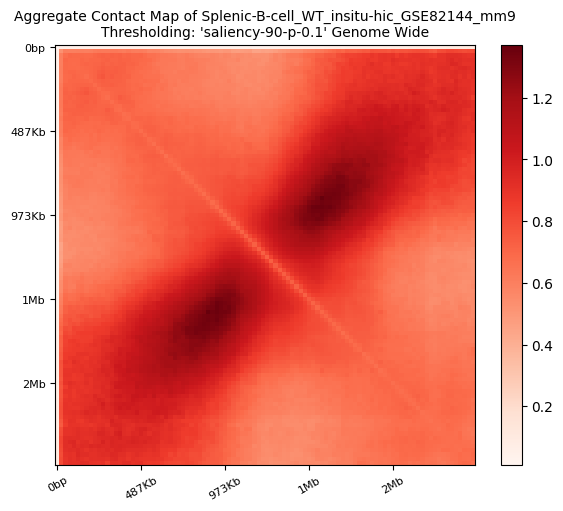

In [36]:
plot_hic(agg_map, 
         resolution=np.mean(resolutions), 
         cmap="Reds",
         title="Aggregate Contact Map of Splenic-B-cell_WT_insitu-hic_GSE82144_mm9\nThresholding: 'saliency-90-p-0.1' Genome Wide")

In [37]:
# Select top jets according to "jet_saliency" column
top_n = 25
sampled_df_stack = df_stack.nlargest(top_n, "jet_saliency").reset_index(drop=True)
sampled_stack = stack[sampled_df_stack.index]

titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
titles += " (saliency: " + sampled_df_stack["jet_saliency"].astype(str) + ")"
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

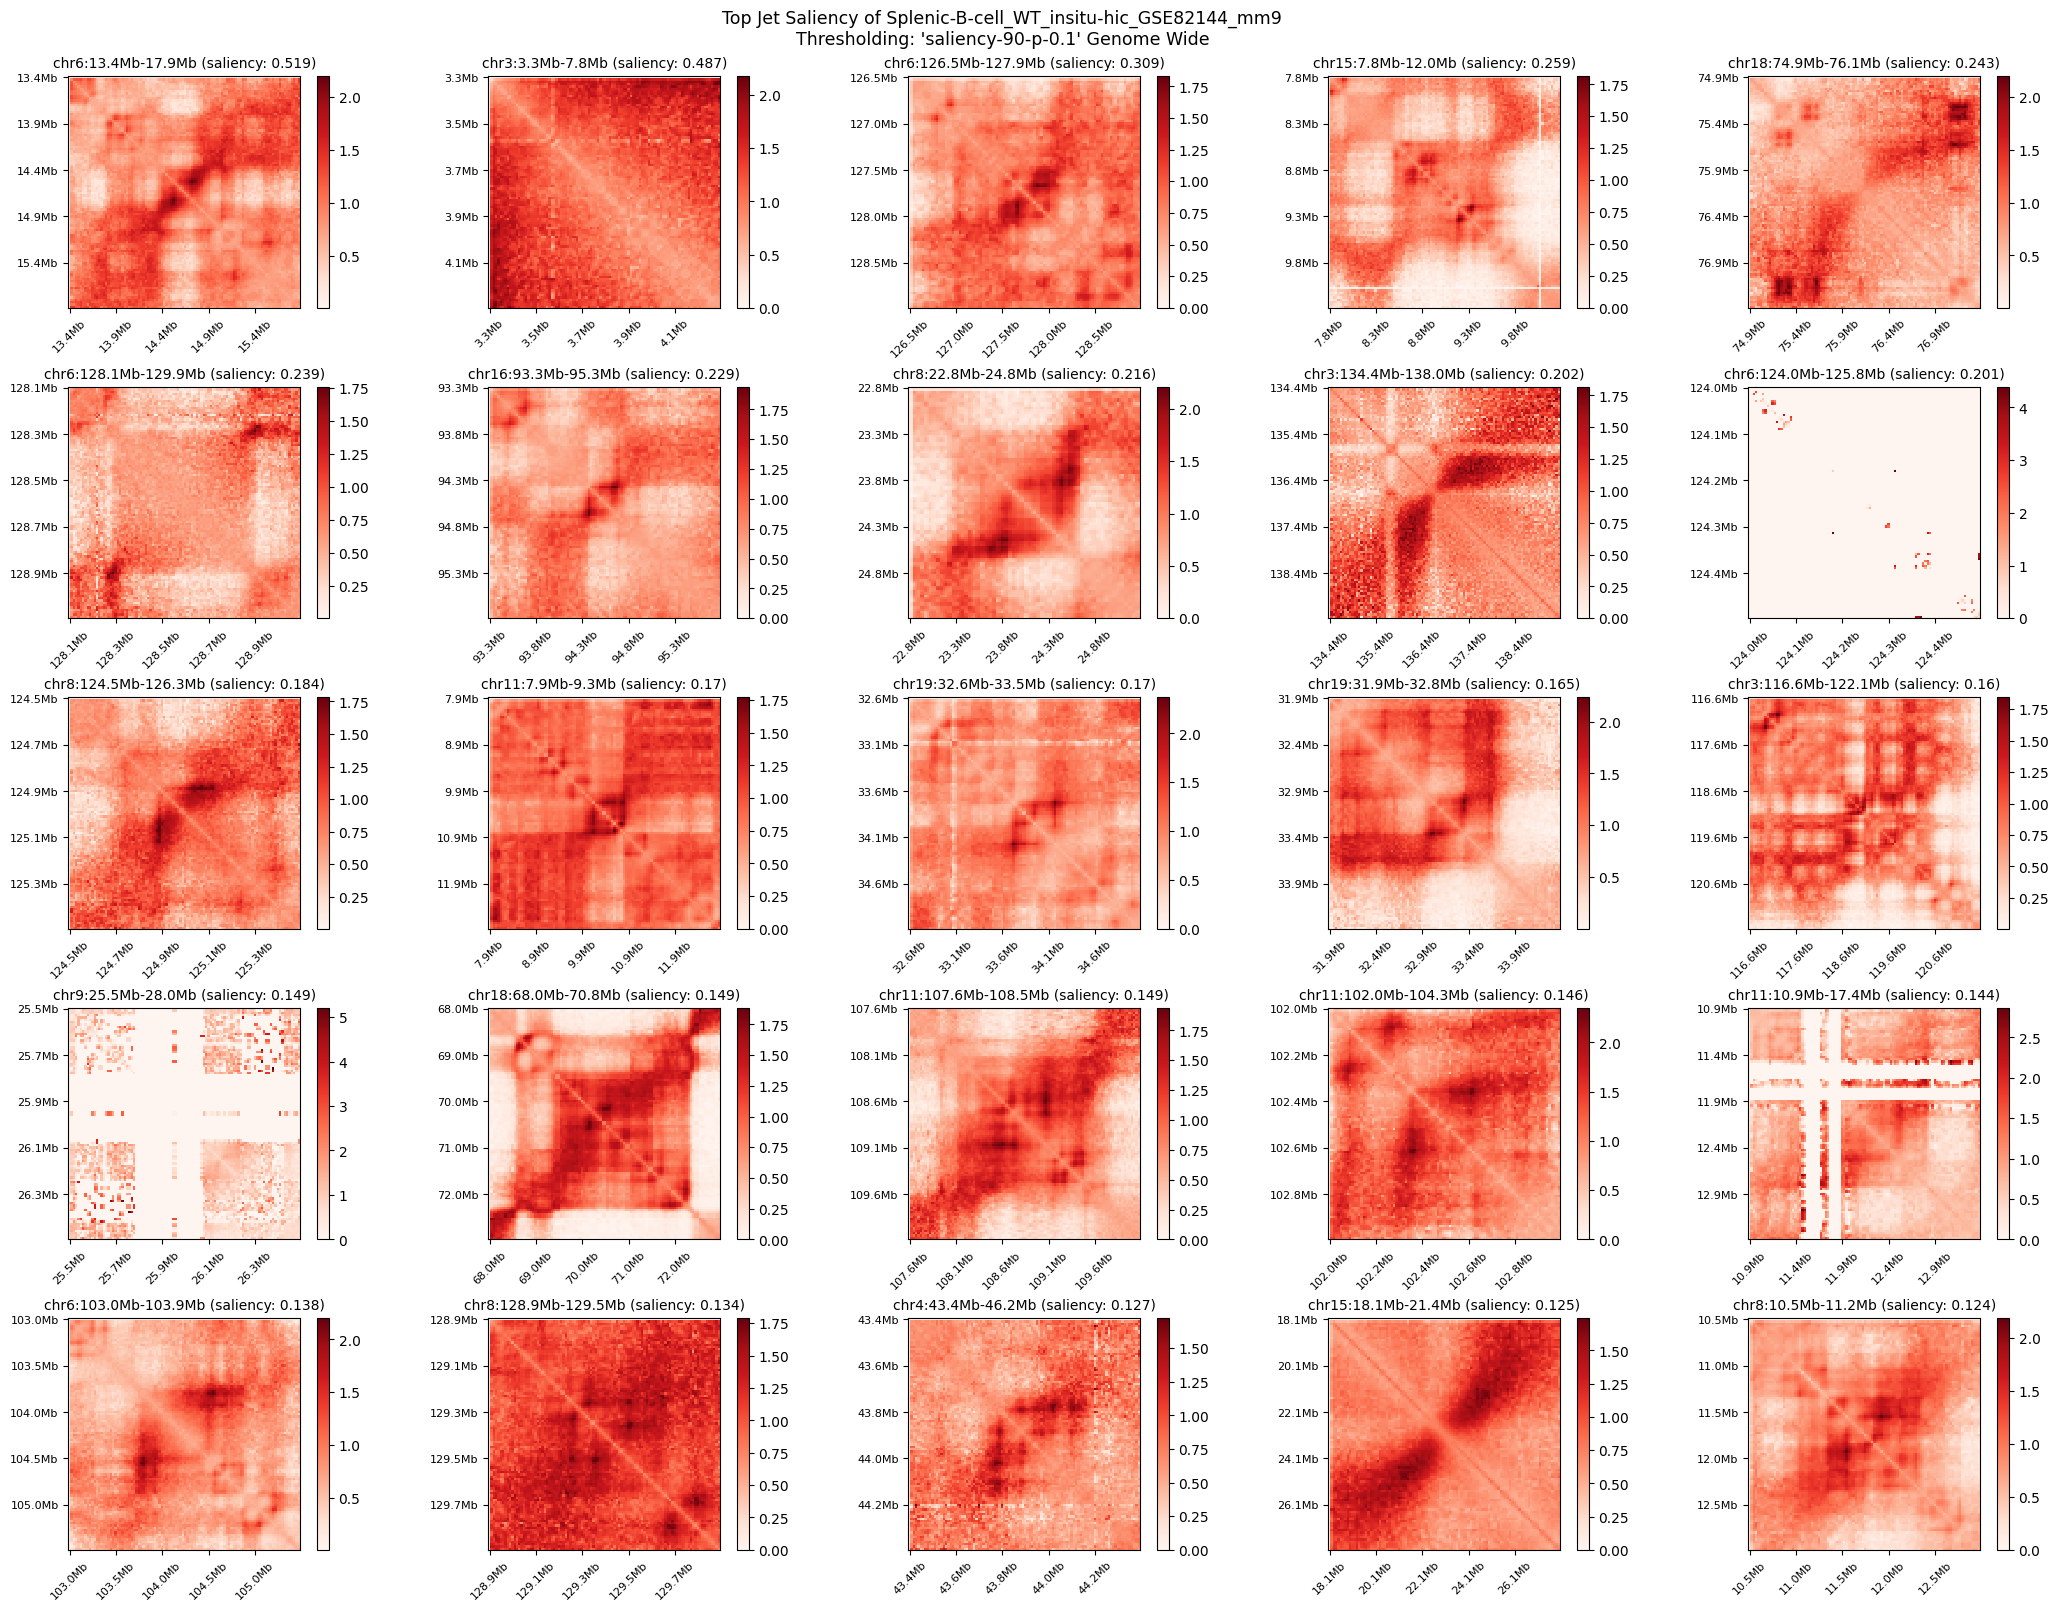

In [38]:
plot_n_hic(sampled_stack, 
           titles=titles, 
           resolution=resolutions,
           suptitle="Top Jet Saliency of Splenic-B-cell_WT_insitu-hic_GSE82144_mm9\nThresholding: 'saliency-90-p-0.1' Genome Wide", 
           show=True, 
           genomic_shift=genomic_shift, 
           cmap_label=None, 
           cmap="Reds")

In [12]:
df_summary.sort_values(by="jet_saliency", ascending=False)

,unique_id,chrom,start,end,length,input_mean,angle_mean,width_mean,jet_saliency,ks,p-val_raw,p-val_corr
58,chr6_17_12,chr6,1.456274e+07,1.671776e+07,1060660.172,0.357,89.427,8.518,0.519,0.667,0.000,0.000
140,chr3_12_13,chr3,4.444861e+06,6.602079e+06,1060660.172,0.261,92.539,8.546,0.487,0.933,0.000,0.000
59,chr6_2957_4,chr6,1.268523e+08,1.275090e+08,318198.052,0.279,94.546,3.391,0.309,0.778,0.003,0.021
112,chr15_1_20,chr15,8.861473e+06,1.090209e+07,989949.494,0.203,86.023,11.525,0.259,0.750,0.000,0.000
83,chr18_1144_6,chr18,7.518227e+07,7.579311e+07,282842.712,0.318,103.847,3.840,0.243,0.750,0.009,0.070
...,...,...,...,...,...,...,...,...,...,...,...,...
26,chr14_1151_10,chr14,7.673134e+07,7.744393e+07,353553.391,0.019,91.140,4.207,0.008,0.800,0.001,0.010
110,chr12_12_18,chr12,9.272956e+07,9.571572e+07,1308147.545,0.037,55.719,7.375,0.007,0.459,0.000,0.006
15,chr17_3036_2,chr17,6.505803e+06,7.107545e+06,282842.712,0.054,104.137,3.094,0.007,0.875,0.001,0.012
27,chr14_38_11,chr14,5.695280e+07,5.778026e+07,388908.730,0.014,85.754,4.433,0.007,0.727,0.002,0.018


In [46]:
df_summary.loc[df_summary["unique_id"] == "chr3_12_13", "start"] 

140    3.255521e+06
Name: start, dtype: float64

In [40]:
df_expanded.loc[df_expanded["unique_id"] == "chr3_12_13"]

,unique_id,chrom,x (bp),y (bp),x (pixels),y (pixels),width,angle_imagej,ridge_strength
2013,chr3_12_13,chr3,5680926.422,5370085.557,156.699,79.750,5.879,90.370,0.013
2014,chr3_12_13,chr3,5716262.751,5335441.485,156.709,78.760,4.397,90.507,0.014
2015,chr3_12_13,chr3,5751713.259,5300908.094,156.722,77.770,4.312,90.658,0.016
2016,chr3_12_13,chr3,5787020.229,5266231.864,156.731,76.781,4.226,90.813,0.018
2017,chr3_12_13,chr3,5822159.972,5231389.106,156.735,75.791,4.141,90.967,0.020
2018,chr3_12_13,chr3,5857126.487,5196375.922,156.734,74.801,4.055,91.104,0.021
2019,chr3_12_13,chr3,5891861.100,5161136.434,156.727,73.812,3.970,91.207,0.023
2020,chr3_12_13,chr3,5926316.073,5125621.508,156.712,72.822,3.885,91.257,0.024
2021,chr3_12_13,chr3,5960542.655,5089878.889,156.691,71.833,3.799,91.246,0.025
2022,chr3_12_13,chr3,5993323.381,5052725.415,156.629,70.844,5.310,91.143,0.026


In [23]:
# Randomly sample 25 jets from the stack
np.random.seed(23)  
sampled_indices = np.random.choice(len(df_stack), size=25, replace=False)
sampled_stack = stack[sampled_indices]
sampled_df_stack = df_stack.iloc[sampled_indices]

titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

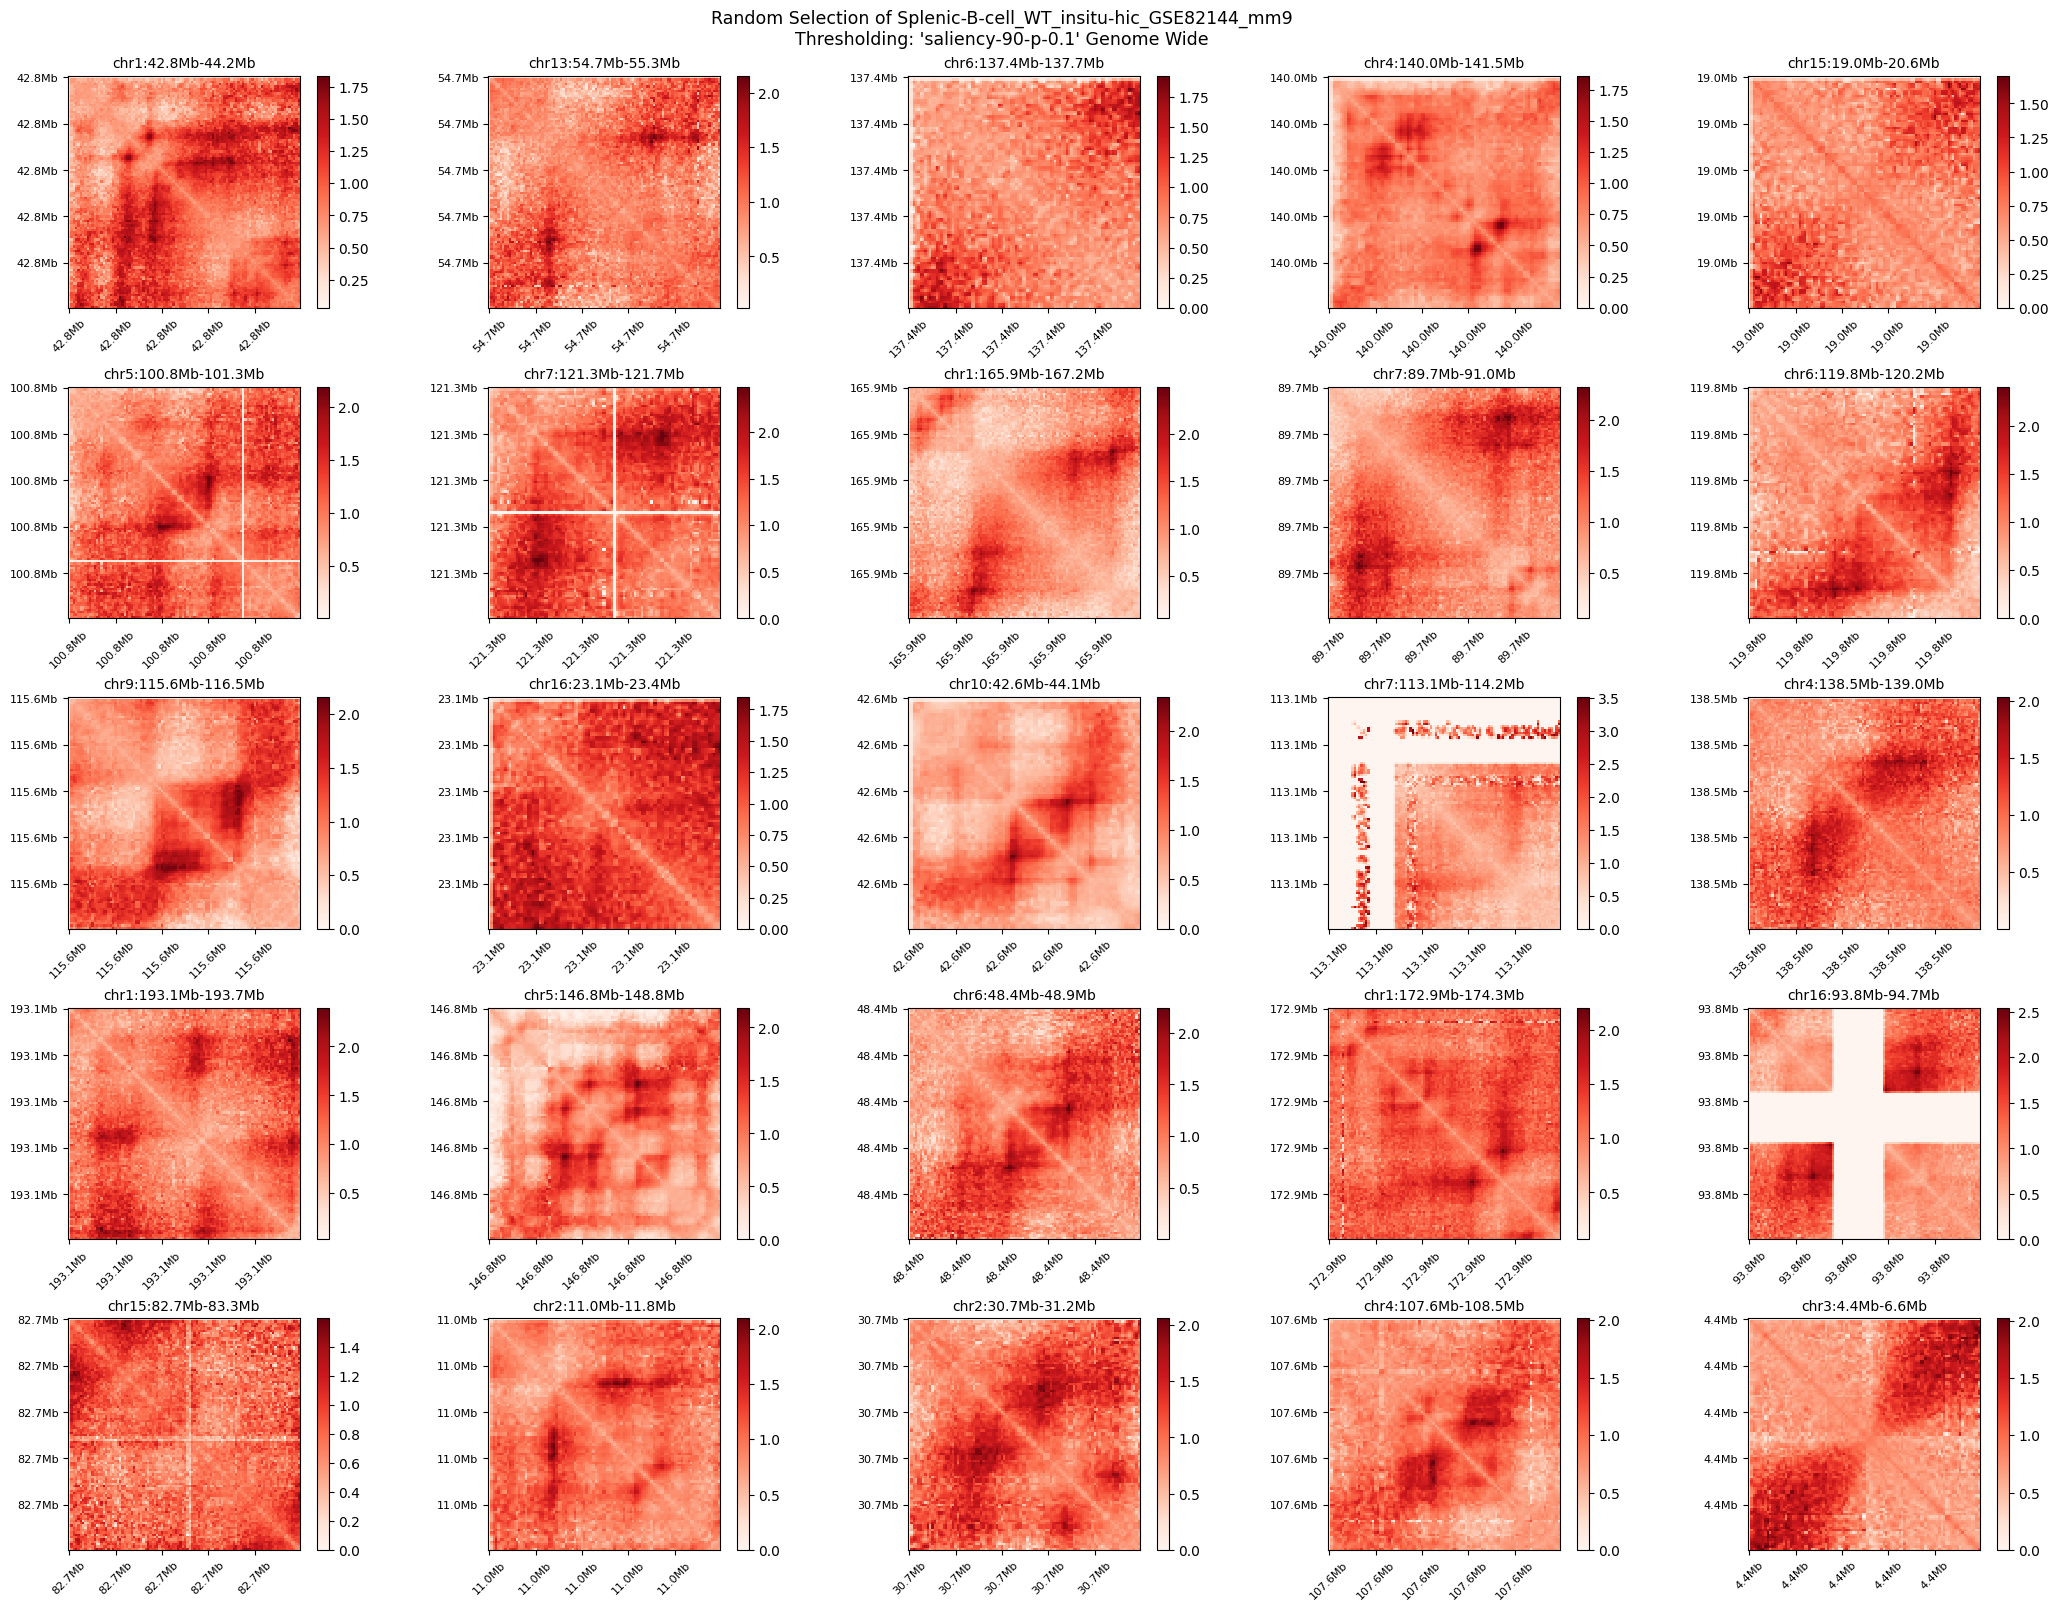

In [25]:
plot_n_hic(sampled_stack, 
           titles=titles, 
           resolution=1,
           suptitle="Random Selection of Splenic-B-cell_WT_insitu-hic_GSE82144_mm9\nThresholding: 'saliency-90-p-0.1' Genome Wide", 
           show=True, 
           genomic_shift=genomic_shift, 
           cmap_label=None, 
           cmap="Reds")